In [2]:
# ! pip install adlfs

In [3]:
%matplotlib inline 
import xarray as xr
import numpy as np
import os 

from adlfs import AzureBlobFileSystem

'''import dask.distributed as dd
import dask
import rhg_compute_tools.kubernetes as rhgk'''

'import dask.distributed as dd\nimport dask\nimport rhg_compute_tools.kubernetes as rhgk'

In [24]:
import matplotlib.pyplot as plt

In [4]:
'''import gcsfs
fs = gcsfs.GCSFileSystem(token='/opt/gcsfuse_tokens/impactlab-data.json')'''

"import gcsfs\nfs = gcsfs.GCSFileSystem(token='/opt/gcsfuse_tokens/impactlab-data.json')"

In [25]:
gcs_cmip6_storepath = 'gs://impactlab-data-scratch/regrid-test-tfh2s/ACCESS-ESM1-5/tasmax/gcm-future-regrid.zarr'
gcs_bc_storepath = 'gs://impactlab-data-scratch/regrid-test-tfh2s/ACCESS-ESM1-5/tasmax/biascorrected-rechunked.zarr'

In [26]:
cmip6 = xr.open_zarr(fs.get_mapper(gcs_cmip6_storepath))
cmip6_slice = cmip6.isel(time=0).load()

In [32]:
# biascorrected = xr.open_zarr(fs.get_mapper(gcs_bc_storepath))
bc_slice = biascorrected.isel(time=0).load()

In [5]:
fs_az = AzureBlobFileSystem(
        account_name='dc6',
        account_key='', 
        client_id=os.environ.get("AZURE_CLIENT_ID", None),
        client_secret=os.environ.get("AZURE_CLIENT_SECRET", None),
        tenant_id=os.environ.get("AZURE_TENANT_ID", None))

In [14]:
downscaled_az_storepath = 'scratch/downscale-aiqpd-test-7kxvn/downscale-aiqpd-test-7kxvn-3844356238/downscaled.zarr'
downscaled_az_store = fs_az.get_mapper(downscaled_az_storepath, check=False)

In [17]:
biascorrected_az_storepath = 'scratch/downscale-aiqpd-test-7kxvn/downscale-aiqpd-test-7kxvn-3033360617/regridded.zarr'
biascorrected_az_store = fs_az.get_mapper(biascorrected_az_storepath, check=False)

In [39]:
biascorrected_coarse_az_storepath = 'az://scratch/dc6-qdm-chunks-test-fwxj6/dc6-qdm-chunks-test-fwxj6-4261986766/qdm_adjusted.zarr'
biascorrected_coarse_az_store = fs_az.get_mapper(biascorrected_coarse_az_storepath, check=False)

In [18]:
ds_downscaled = xr.open_zarr(downscaled_az_store)

In [19]:
ds_biascorrected = xr.open_zarr(biascorrected_az_store)

In [40]:
ds_coarse_biascorrected = xr.open_zarr(biascorrected_coarse_az_store)

In [41]:
ds_coarse_biascorrected

,Array,Chunk
Bytes,6.15 GB,525.60 kB
Shape,"(23725, 180, 360)","(73, 10, 180)"
Count,11701 Tasks,11700 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,6.15 GB,9.49 MB
Shape,"(23725, 180, 360)","(23725, 10, 10)"
Count,649 Tasks,648 Chunks
Type,float32,numpy.ndarray


In [36]:
ds_downscaled

,Array,Chunk
Bytes,98.39 GB,8.41 MB
Shape,"(23725, 720, 1440)","(365, 4, 1440)"
Count,11701 Tasks,11700 Chunks
Type,float32,numpy.ndarray


In [31]:
ds_downscaled_slice = ds_downscaled['tasmin'].isel(time=0).load()

In [42]:
ds_coarse_biascorrected_slice = ds_coarse_biascorrected['tasmin'].isel(time=0).load()

In [32]:
ds_biascorrected_slice = ds_biascorrected['tasmin'].isel(time=0).load()

Text(0.5, 1.0, 'Downscaled - Bias corrected')

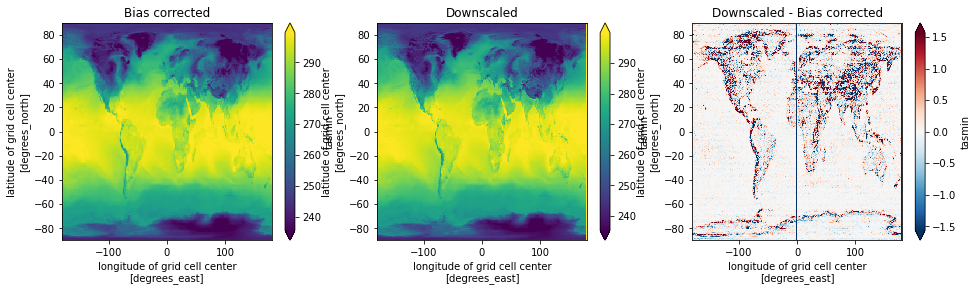

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ds_biascorrected_slice.plot(ax=axes[0], robust=True)
axes[0].set_title('Bias corrected')

ds_downscaled_slice.plot(ax=axes[1], robust=True)
axes[1].set_title('Downscaled')

(ds_downscaled_slice - ds_biascorrected_slice).plot(ax=axes[2], robust=True)
axes[2].set_title('Downscaled - Bias corrected')

check resampling of bias corrected from coarse to fine from pipeline (is xesmf doing the same thing as xarray's broadcast_like?)

In [51]:
# rainy_sif_xds.interp(lat=rainy_imerg_xds["lat"], lon=rainy_imerg_xds["lon"])
ds_coarse_biascorrected_slice_resampled = ds_coarse_biascorrected_slice.drop(['sim_q', 'time']).broadcast_like(ds_biascorrected_slice.drop('time'))

In [65]:
ds_biascorrected_slice[:12, :12].values

array([[240.55974, 240.55974, 240.55974, 240.55974, 240.55498, 240.55498,
        240.55498, 240.55498, 240.54973, 240.54973, 240.54973, 240.54973],
       [240.55974, 240.55974, 240.55974, 240.55974, 240.55498, 240.55498,
        240.55498, 240.55498, 240.54973, 240.54973, 240.54973, 240.54973],
       [240.55974, 240.55974, 240.55974, 240.55974, 240.55498, 240.55498,
        240.55498, 240.55498, 240.54973, 240.54973, 240.54973, 240.54973],
       [240.55974, 240.55974, 240.55974, 240.55974, 240.55498, 240.55498,
        240.55498, 240.55498, 240.54973, 240.54973, 240.54973, 240.54973],
       [242.15562, 242.15562, 242.15562, 242.15562, 242.16008, 242.16008,
        242.16008, 242.16008, 242.16121, 242.16121, 242.16121, 242.16121],
       [242.15562, 242.15562, 242.15562, 242.15562, 242.16008, 242.16008,
        242.16008, 242.16008, 242.16121, 242.16121, 242.16121, 242.16121],
       [242.15562, 242.15562, 242.15562, 242.15562, 242.16008, 242.16008,
        242.16008, 242.16008, 24

In [56]:
ds_biascorrected_slice.drop('time')

<xarray.DataArray 'tasmin' (lat: 720, lon: 1440)>
array([[240.55974, 240.55974, 240.55974, ..., 240.56433, 240.56433,
        240.56433],
       [240.55974, 240.55974, 240.55974, ..., 240.56433, 240.56433,
        240.56433],
       [240.55974, 240.55974, 240.55974, ..., 240.56433, 240.56433,
        240.56433],
       ...,
       [245.00912, 245.00912, 245.00912, ..., 245.01022, 245.01022,
        245.01022],
       [245.00912, 245.00912, 245.00912, ..., 245.01022, 245.01022,
        245.01022],
       [245.00912, 245.00912, 245.00912, ..., 245.01022, 245.01022,
        245.01022]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [19]:
cmip6_az_storepath = 'az://scratch/regrid-test-tfh2s/regrid-test-tfh2s-2203207529/out.zarr'
# bc_az_storepath = 'az://scratch/regrid-test-8mlww/regrid-test-8mlww-546537503/out.zarr'

In [20]:
gcs_cmip6_storepath = 'gs://impactlab-data/climate/downscaling/biascorrected-validation-20210802/ACCESS-ESM1-5/tasmax/gcm-future-regrid.zarr'
gcs_bc_storepath = 'gs://impactlab-data/climate/downscaling/biascorrected-validation-20210730/ACCESS-ESM1-5/tasmax/biascorrected-rechunked.zarr'

In [21]:
# cmip6_az_store = fs_az.get_mapper(cmip6_az_storepath, check=False)

In [1]:
cmip6_az_store = fs_az.get_mapper(cmip6_az_storepath, check=False)
cmip6_zarr = xr.open_zarr(cmip6_az_store, consolidated=False)

'cmip6_az_store = fs_az.get_mapper(cmip6_az_storepath, check=False)\ncmip6_zarr = xr.open_zarr(cmip6_az_store, consolidated=False)'